In [1]:
import numpy as np
import os
datadir = 'multirun/2024-01-17/16-04-20/'
import pandas as pd
import yaml
import json
import jax
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib widget
import seaborn as sns
from tqdm.notebook import tqdm
sns.set()

In [2]:
dirs = [os.path.join(datadir, x) for x in next(os.walk(datadir))[1]]
dirs.sort(key=lambda x: int(x.split('/')[-1]))

In [3]:
a = np.load(os.path.join(dirs[0], 'result.npz'))
conf = os.path.join(os.path.join(dirs[0], '.hydra'), 'hydra.yaml')
with open(conf, "r") as file:
    d = yaml.safe_load(file)

In [13]:
d['hydra']['overrides']['task']

['alg=SHGP', 'bf.m=10', 'experiment=precipitation']

### Read experiment results

In [75]:
import pdb
def read_results(dirs):
    alg = None
    results = {}
    for path in dirs:
        conf = os.path.join(os.path.join(path, '.hydra'), 'hydra.yaml')
        with open(conf, "r") as file:
            d = yaml.safe_load(file)
        try:
            data = dict(np.load(os.path.join(path, 'result.npz')))
        except:
            continue
    
        for override in d['hydra']['overrides']['task']:
            if 'alg=' in override:
                alg = override.split("=")[-1]
        if alg in results.keys():
            for key, val in data.items():
                results[alg][key].append(val)
        else:
            results[alg] = {key: [val] for key, val in data.items()}
        alg = None
    return results
# results = read_results(dirs, "lengthscale")

In [76]:
results = read_results(dirs)
results = {alg: {key: np.array(val) for key, val in algres.items()} for alg, algres in results.items()}

### Example plot of the timings for the model variants -- for demonstration purposes

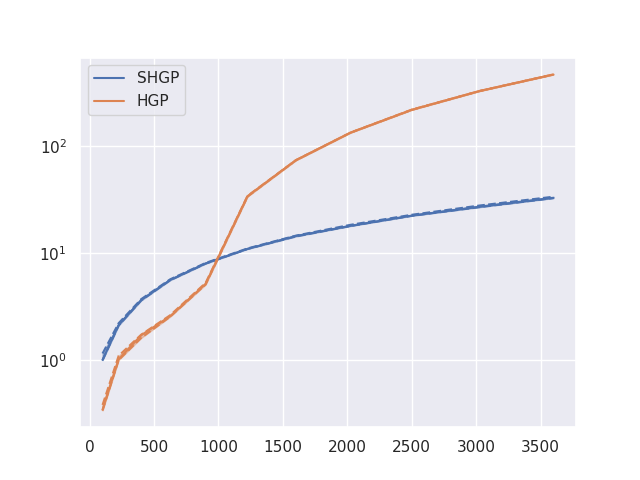

In [77]:
plt.figure()
for alg, algres in results.items():
    tmin = algres['times'].min(axis=1)
    tmax = algres['times'].max(axis=1)
    tmed = np.median(algres['times'], axis=1)
    l = plt.plot(algres['m'], tmed, label=alg)[0]
    plt.plot(algres['m'], tmax, '--', color=l.get_color())
    plt.plot(algres['m'], tmin, '--', color=l.get_color())
    plt.fill_between(algres['m'], tmin, tmax, color=l.get_color(), alpha=0.4)
plt.yscale("log")
plt.legend()
plt.show()

### Save to CSV for plotting in TikZ

In [78]:
to_csv = {}
for alg, algres in results.items():
    tmin = algres['times'].min(axis=1)
    tmax = algres['times'].max(axis=1)
    tmed = np.median(algres['times'], axis=1)
    tmean = np.mean(algres['times'], axis=1)
    tstd = np.std(algres['times'], axis=1)
    to_csv[alg] = dict(t_min=tmin,
                        t_max=tmax,
                        t_median=tmed,
                        t_mean=tmean,
                        t_std=tstd,
                        m=algres['m'])

In [80]:
import pandas as pd
for model, val in to_csv.items():
    D = pd.DataFrame(val)
    with open(model+'precipitation_timing.csv', "w") as file:
        D.to_csv(file, index=False)

### Predictions w/ particular model
For prediction plotting purposes.

In [3]:
from fastHGP.utils import load_model
k = 8
a = np.load(os.path.join(dirs[k], 'result.npz'))
modelfile = os.path.join(dirs[k], 'model')
conf = os.path.join(os.path.join(dirs[k], '.hydra'), 'hydra.yaml')
with open(conf, "r") as file:
    d = yaml.safe_load(file)
model = load_model(modelfile)

In [4]:
shgp = load_model("outputs/2024-01-22/10-59-43/shgp")
gp = load_model("outputs/2024-01-22/10-59-43/full_gp")

In [5]:
import scipy.io as sio
from fastHGP.examples.precipitation import generate_data
D = generate_data()
data = sio.loadmat("data/data.mat")
X, y = data['x'], data['y']
boundary = np.array([X.min(axis=0), X.max(axis=0)]) # For centering of the data
plotdata = sio.loadmat("data/usavertices.mat") # Vertices to predict at
xtest = plotdata['vertices'] - boundary.mean(axis=0) # Center

i = 0
shgp_preds = []
# Have to do batch predictions due to how GPJax works -- the returned GaussianDistribution would otherwise be 57000 dimensional, which is a bit large.
for k in tqdm(range(3000, xtest.shape[0], 3000)):
    yhat, _ = shgp.predict(xtest[i:k], full_cov=False)
    i = k
    shgp_preds.append(yhat.mean())
yhat, _ = shgp.predict(xtest[k:], full_cov=False)
shgp_preds.append(yhat.mean())
shgp_preds = np.concatenate(shgp_preds)

  0%|          | 0/19 [00:00<?, ?it/s]

In [6]:
import cola
import jax.numpy as jnp
from gpjax.distributions import GaussianDistribution
train_data = D
x, y = train_data.X, train_data.y
Kxx = gp.prior.kernel.gram(x)
Kxx += cola.ops.I_like(Kxx) * gp.jitter

# Σ = Kxx + Io²
Sigma = Kxx + cola.ops.I_like(Kxx) * gp.likelihood.obs_stddev**2
Sigma_inv = jnp.linalg.inv(Sigma.to_dense()) # Obviously not a "good way" of doing this, but due to the sheer number of prediction locations, this is most efficient
# Sigma_inv = cola.inv(Sigma).to_dense()
mx = gp.prior.mean_function(x)
e = y - mx

def gp_predict(gp, xtest):
    mean_t = gp.prior.mean_function(xtest)
    Ktt = gp.prior.kernel.gram(xtest)
    Kxt = gp.prior.kernel.cross_covariance(x, xtest)
    Sigma_inv_Kxt = Sigma_inv @ Kxt
    
    # μt  +  Ktx (Kxx + Io²)⁻¹ (y  -  μx)
    mean = mean_t + jnp.matmul(Sigma_inv_Kxt.T, e)
    
    # Ktt  -  Ktx (Kxx + Io²)⁻¹ Kxt, TODO: Take advantage of covariance structure to compute Schur complement more efficiently.
    covariance = Ktt - jnp.matmul(Kxt.T, Sigma_inv_Kxt)
    covariance += cola.ops.I_like(covariance) * gp.prior.jitter
    covariance = cola.PSD(covariance)
    
    return GaussianDistribution(jnp.atleast_1d(mean.squeeze()), covariance)

In [7]:
i = 0
gp_preds = []
# Have to do batch predictions due to how GPJax works -- the returned GaussianDistribution would otherwise be 57000 dimensional, which is a bit large.
for k in tqdm(range(3000, xtest.shape[0], 3000)):
    yhat = gp_predict(gp, xtest[i:k])
    i = k
    gp_preds.append(yhat.mean())
yhat = gp_predict(gp, xtest[k:])
gp_preds.append(yhat.mean())
gp_preds = np.concatenate(gp_preds)

  0%|          | 0/19 [00:00<?, ?it/s]

### Predictions 

In [8]:
import scipy.io as sio
from fastHGP.examples.precipitation import generate_data
D = generate_data()
data = sio.loadmat("data/data.mat")
X, y = data['x'], data['y']
boundary = np.array([X.min(axis=0), X.max(axis=0)]) # For centering of the data
plotdata = sio.loadmat("data/usavertices.mat") # Vertices to predict at
xtest = plotdata['vertices'] - boundary.mean(axis=0) # Center
i = 0
preds = []
# Have to do batch predictions due to how GPJax works -- the returned GaussianDistribution would otherwise be 57000 dimensional, which is a bit large.
for k in tqdm(range(5000, xtest.shape[0], 5000)):
    yhat, _ = model.predict(xtest[i:k], full_cov=False)
    i = k
    preds.append(yhat.mean())
yhat, _ = model.predict(xtest[k:], full_cov=False)
preds.append(yhat.mean())
preds = np.concatenate(preds)

  0%|          | 0/11 [00:00<?, ?it/s]

In [7]:
gp = model.prior * model.likelihood
i = 0
gp_preds = []
# Have to do batch predictions due to how GPJax works -- the returned GaussianDistribution would otherwise be 57000 dimensional, which is a bit large.
for k in tqdm(range(1000, xtest.shape[0], 1000)):
    yhat, _ = gp.predict(xtest[i:k], train_data=D)
    i = k
    preds.append(yhat.mean())
yhat, _ = gp.predict(xtest[k:], train_data=D)
gp_preds.append(yhat.mean())
gp_preds = np.concatenate(gp_preds)

  0%|          | 0/59 [00:00<?, ?it/s]

NameError: name 'D' is not defined

In [9]:
# Load data for plotting purposes -- conus is *not* freely available, but available through MATLABs Mapping Toolbox
import shapely
usdata = sio.loadmat("data/conus.mat")
outline = np.hstack([usdata['uslon'], usdata['uslat']])
statelines = np.hstack([usdata['statelon'], usdata['statelat']])
lakelines = np.hstack([usdata['gtlakelon'], usdata['gtlakelat']])
cont_us = shapely.Polygon(outline[~np.isnan(outline).all(axis=1)])
inds = np.array([cont_us.contains(shapely.Point(point)) or np.isnan(point).any() for point in lakelines]).flatten()
lakelines[~inds] = np.nan

In [33]:
from matplotlib.tri import Triangulation
from matplotlib.collections import TriMesh
from pyproj import Transformer
llh_to_xyz = Transformer.from_crs(4326, 5070)
# Transforms lat/lon to local coordinates through a spherical transform
xp, yp = llh_to_xyz.transform(plotdata['vertices'][:,1], plotdata['vertices'][:,0])

# Creates triangulation from the (projected) vertex data
tri = Triangulation(x=xp, y=yp, triangles=plotdata['faces']-1)
# Project to local coordinate system and plot
def convert_and_plot(data, ax=plt.gca(), **kwargs):
    xp, yp = llh_to_xyz.transform(data[:,1], data[:,0])
    ax.plot(xp, yp, **kwargs)

In [11]:
import matplotlib
print(list(matplotlib.colormaps))

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', 'Blues_r', 'BrBG_r', 'BuGn_r', 'BuPu_r', 'CMRmap_r', 'GnBu_r', 'G

In [48]:
import matplotlib
import tikzplotlib
offset = 937.5809/100 # Offset from Vanhatalo, J., and Vehtari, A. (2008)
cmap = matplotlib.colormaps['jet'].resampled(64)
norm = matplotlib.colors.Normalize(vmin=0, vmax=30)
def plot_precipitation(preds, filename=None):
    tmp_preds = preds.copy() + offset # Offset w/ mean of original data 
    colors = cmap(norm(tmp_preds))
    with sns.axes_style("white"):
        fig, ax = plt.subplots(layout="constrained")
        coll = TriMesh(tri, facecolors=colors)
        convert_and_plot(outline, ax, color='k', lw=0.5)
        convert_and_plot(statelines, ax, color='w', lw=.75)
        convert_and_plot(lakelines, ax, color='w', lw=0.75)
        ax.set_xlim([xp.min(), xp.max()])
        ax.set_ylim([yp.min(), yp.max()])
        ax.add_collection(coll)
        # cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
        #                      ax=ax, orientation='horizontal', shrink=.5)
        # cbar.ax.text(1.1, -1.5, '[mm]', transform=cbar.ax.transAxes)
        # # pos = [preds.min(), (preds.max()+preds.min())/2, preds.max()]
        # pos = [0, 15, 30]
        # cbar.set_ticks(pos, labels=[0, 1500, 3000]) # The data is centered from before -- however, these are the corresponding predictions.
        sns.despine(left=True, bottom=True)
        ax.set_xticks([])
        ax.set_yticks([])
        if filename is not None:
            plt.savefig(filename, bbox_inches='tight')
    return norm, cmap

(<matplotlib.colors.Normalize at 0x7fbe013afd50>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7fbe041623d0>)

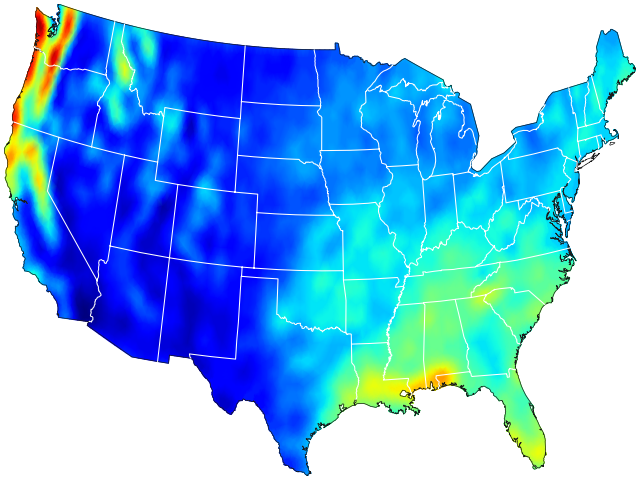

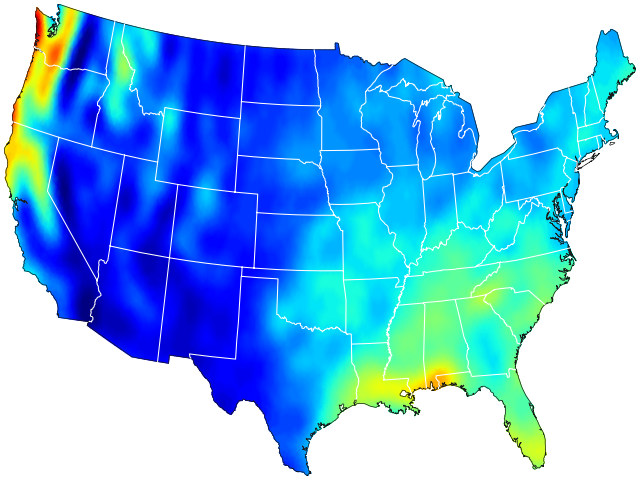

In [49]:
plt.close("all")
norm, cmap = plot_precipitation(gp_preds, filename="precipitation_fullgp.eps")
plot_precipitation(preds, filename="precipitation_shgp.eps")

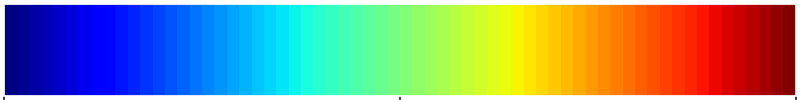

In [50]:
plt.close("all")
fig, ax  = plt.subplots(figsize=(8, 1), layout="constrained")
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')
pos = [0, 15, 30]
cbar.set_ticks(pos, labels=[None,None,None]) # The data is centered from before -- however, these are the corresponding predictions.
plt.savefig("precipitation_cbar.eps", bbox_inches='tight')

In [27]:
tikzplotlib.get_tikz_code()

'% This file was created with tikzplotlib v0.10.1.\n\\begin{tikzpicture}\n\n\\end{tikzpicture}\n'

In [13]:
help(tikzplotlib.save)

Help on function save in module tikzplotlib._save:

save(filepath: 'str | Path', *args, encoding: 'str | None' = None, **kwargs)
    Same as `get_tikz_code()`, but actually saves the code to a file.
    
    :param filepath: The file to which the TikZ output will be written.
    :type filepath: str
    
    :param encoding: Sets the text encoding of the output file, e.g. 'utf-8'.
                     For supported values: see ``codecs`` module.
    :returns: None

